**Tutorial: Simple 2D data**

This tutorial showcases all the currently supported DRMM priors and constraints with simple 2D data that is easy to visualize. 

First, we have the usual imports and some parameters. We also download DRMM.py from the repository if this notebook is run in Colab.

In [ ]:
import numpy as np
import matplotlib.pyplot as pp
import random
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1" #disable Tensorflow GPU usage, these simple graphs run faster on CPU
import tensorflow as tf
from matplotlib.patches import Ellipse, Rectangle

#Load the DRMM.py from Github if running in a Colab virtual machine
if 'COLAB_GPU' in os.environ:
    !wget https://raw.githubusercontent.com/PerttuHamalainen/DRMM/master/DRMM.py --output-document=DRMM.py

from DRMM import dataStream,DRMM,DataIn

#Training parameters
dataDim=2           #This example uses simple 2D data
nIter=20000         #Number of training iterations (minibatch EM steps)
nBatch=64           #Training minibatch size
nTrainingData=1000  #Synthetic training dataset size

#Model parameters
bwdSampling=False  #Set to true to test backward sampling instead of forward sampling
nComponentsPerLayer=16
nLayers=4

#Inference parameters.  
prunedPortion=0.01  #In range 0...1, amount of least probable samples to prune.

Create a Tensorflow session

In [2]:
sess=tf.Session()

Create and plot 2D Swiss roll data and define a helper function for querying data batches

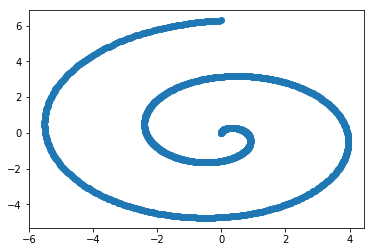

In [3]:
angles=np.reshape(np.linspace(0,4.0*np.pi,nTrainingData),[-1,1])
data=0.5*angles*np.concatenate([np.sin(angles),np.cos(angles)],axis=1)
pp.scatter(data[:,0],data[:,1])

def getDataBatch(nBatch):   
    return data[np.random.randint(data.shape[0], size=nBatch),:]

Model and input data definition and initialization. 

In [4]:
#Define the input data type. Note: the defaults are useBoxConstraints=False, useGaussianPrior=False, and
#maxInequalities=0, which saves some memory and compute.
inputStream=dataStream("continuous",               #This example uses continuous-valued data.
                         shape=[None,dataDim],          #The yet unknown batch size in the first value
                         useBoxConstraints=True,        #We use box constraints
                         useGaussianPrior=True,         #We use a Gaussian prior
                         maxInequalities=2)             #We use up to 2 inequality constraints

#Create model. Note: the constructor takes in the TensorFlow Session, but the model interface is otherwise
#designed to be framework-agnostic, to prepare for upcoming TF2 and PyTorch implementations 
model=DRMM(sess=sess,
                nLayers=nLayers,
                nComponentsPerLayer=nComponentsPerLayer,
                inputs=inputStream,
                initialLearningRate=0.005,
                useBwdSampling=bwdSampling)

#Initialize
tf.global_variables_initializer().run(session=sess)
model.init(getDataBatch(256))  #Data-dependent initialization

Fwd pass, layer RMM, mode=training
Fwd pass, layer RMM, mode=training
Fwd pass, layer RMM, mode=training
Fwd pass, layer RMM, mode=training
Fwd pass, layer RMM, mode=init
Fwd pass, layer RMM, mode=init
Fwd pass, layer RMM, mode=init
Fwd pass, layer RMM, mode=init
Fwd pass, layer RMM, mode=sample_fwd
Fwd pass, layer RMM, mode=sample_fwd
Fwd pass, layer RMM, mode=sample_fwd
Fwd pass, layer RMM, mode=sample_fwd


Train the model

In [5]:
for i in range(nIter):
    '''
    The train method performs a single EM step. 
    The method takes in a batch of data and a training phase variable in range 0...1.
    The latter is used for sweeping the learning rate and E-step \rho, as described in the paper.
    '''
    info=model.train(i/nIter,getDataBatch(nBatch))

    #Print progress
    if i%100==0 or i==nIter-1:
        print("Iteration {}/{}, Loss {:.3f}, learning rate {:.6f}, precision {:.3f}".format(i,nIter,info["loss"],info["lr"],info["rho"]),end="\r")  

Now, we can start exploring the sampling options. First, we visualize the training data and unconditional samples.

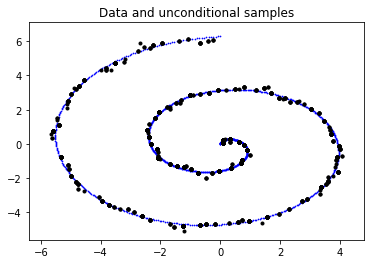

In [6]:
#Helper to ensure all plots are similarly scaled
def setPlotLimits():
    pp.xlim(-6.4,4.8)
    pp.ylim(-5.6,7.1)

#Plot input data
subplotSize=2.5
markerSize=2
pp.scatter(data[:,0],data[:,1],color='b',label='input',marker='.',s=markerSize,zorder=-1)

#Generate samples. In unconditional sampling, we only need to specify the number of samples
samples=model.sample(nSamples=1024)

#Plot
pp.scatter(samples[:,0],samples[:,1],color='black',label='samples, p(x,y)',marker='.')
pp.title("Data and unconditional samples")
setPlotLimits()

Sample y conditional on x

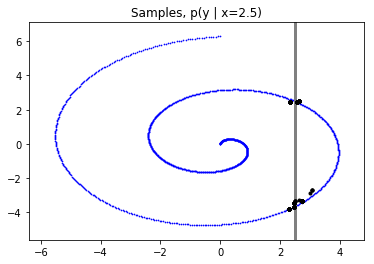

In [7]:
#Conditioning parameters
nCond=256                                   #number of conditional samples
target=2.5                                  #target for x
xIndex=0                                    #x values in column 0

#Conditioning needs an input data batch similar to training, 
#and also a mask of same shape that indicates the conditioning (known) variables.
inputData=np.zeros([nCond,dataDim])         #initialize input data batch to zero
mask=np.zeros([nCond,dataDim])              #initialize masks to zero (all variables unknown)
inputData[:,xIndex]=target                  #set the known variable's value
mask[:,xIndex]=1                            #set the known variable's mask to 1 

#Generate conditional samples. 
#In this case, the nSamples argument is not needed, because it is specified by the data shape.
#We use sorted=True so that the sample array is sorted based on descending probability density,
#and it's easy to prune outliers (see below)
samples=model.sample(inputs=DataIn(data=inputData,mask=mask),sorted=True)

#Prune the least probable (outlier) samples. This is easy, as we use sorted=True above, i.e., 
if prunedPortion>0:
    samples=samples[:int(nCond*(1.0-prunedPortion))] 

#Plot
pp.scatter(data[:,0],data[:,1],color='b',marker='.',s=markerSize,zorder=-1)
pp.plot([target,target],[-10,10],color="gray",lw=3.0,zorder=-0.5) #visualize the target x 
pp.scatter(samples[:,0],samples[:,1],color='black',marker='.')
setPlotLimits()
pp.title("Samples, p(y | x={})".format(target))
setPlotLimits()

Sample using two linear inequality constraints (dot(a,x)+b>0), confining the samples to a slice of the 2D space.

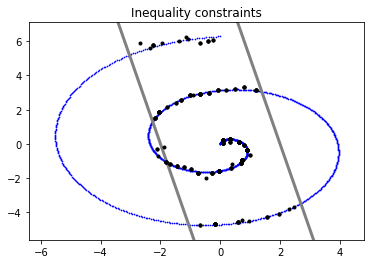

In [8]:
#The inequalities are defined as a list of dictionaries. 
#The number of dictionaries must be less than equal to the maxInequalities parameter passed to the model constructor.
ieqs=[{"a":np.array([1.0,0.2]),"b":2.0},{"a":np.array([-1.0,-0.2]),"b":2.0}]

#Sample and prune the least probable (outlier) samples
samples=model.sample(nSamples=nCond,inputs=DataIn(ieqs=ieqs),sorted=True)
if prunedPortion>0:
    samples=samples[:int(nCond*(1.0-prunedPortion))] 

#Plot
pp.scatter(data[:,0],data[:,1],color='b',marker='.',s=markerSize,zorder=-1)
for ieq in ieqs:
    #Plot the constraint boundary line
    #a0*x0+a1*x1+b=0 => x1=(-a0*x0-b)/a1
    x0=np.array([-5.0,5.0])
    a0=ieq["a"][0]
    a1=ieq["a"][1]
    x1=(-a0*x0-ieq["b"])/a1
    pp.plot(x0,x1,color="gray",lw=3.0,scalex=False,scaley=False,zorder=-0.5) 
pp.scatter(samples[:,0],samples[:,1],color='black',marker='.')
pp.title("Inequality constraints")
setPlotLimits()

Generate and plot samples with box constraints, i.e., limits for maximum and minimum values

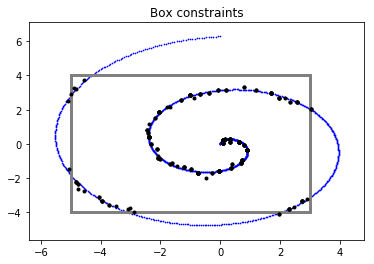

In [9]:
#The min and max values for each coordinate
minValues=np.array([-5.0,-4.0])
maxValues=np.array([3.0,4.0])

#Sample and prune the least probable (outlier) samples
samples=model.sample(nSamples=nCond,inputs=DataIn(minValues=minValues,maxValues=maxValues),sorted=True)
if prunedPortion>0:
    samples=samples[:int(nCond*(1.0-prunedPortion))] 

#Plot
pp.scatter(data[:,0],data[:,1],color='b',marker='.',s=markerSize,zorder=-1)
pp.gca().add_patch(Rectangle(minValues,width=(maxValues-minValues)[0],height=(maxValues-minValues)[1],facecolor='none',edgecolor="gray",lw=3.0,zorder=-0.5)) 
pp.scatter(samples[:,0],samples[:,1],color='black',marker='.')
pp.title("Box constraints")
setPlotLimits()

Finally, sample using a Gaussian prior

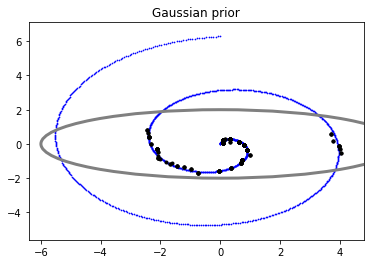

In [10]:
#Define the prior (only diagonal Covariance supported)
priorMean=np.array([0.0,0.0])
priorSd=np.array([3.0,1.0])

#Sample and prune the least probable (outlier) samples
samples=model.sample(nSamples=nCond,inputs=DataIn(priorMean=priorMean,priorSd=priorSd),sorted=True)
if prunedPortion>0:
    samples=samples[:int(nCond*(1.0-prunedPortion))] 

#Plot
pp.scatter(data[:,0],data[:,1],color='b',marker='.',s=markerSize,zorder=-1)
pp.gca().add_patch(Ellipse(priorMean,width=4.0*priorSd[0],height=4.0*priorSd[1],facecolor='none',edgecolor="gray",lw=3.0,zorder=-0.5)) #4.0 multiplier to make the ellipse correspond to two standard deviations
pp.scatter(samples[:,0],samples[:,1],color='black',marker='.')
pp.title("Gaussian prior")
setPlotLimits()